In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import json
import pandas as pd
import os
import seaborn as sns

In [ ]:
import wandb 

api = wandb.Api()

api_path = 'lv2-ss-/semantic-segmentation/12w5vgm3'

In [11]:
def get_metrics(api_path):
    run = api.run(api_path)
    summary = run.summary
    class_dice = {}
    for key, value in summary.items():
        if "val" in key :
            if "dice" in key or "loss" in key:
                continue
            class_dice[key.split("/")[1]] = value
    return run, summary, class_dice

In [16]:
def df_class_dice(class_dice):
    # dictionary를 데이터프레임으로 변환
    class_dice_df = pd.DataFrame({
        'class': list(class_dice.keys()),
        'dice': list(class_dice.values())
    })

    # 각 클래스의 타입(finger/wrist) 정보 추가
    class_dice_df['type'] = class_dice_df['class'].apply(lambda x: 'finger' if x.startswith('finger') else 'wrist' if x.startswith('Radius') or x.startswith('Ulna') else 'backhand')
    type_means = class_dice_df.groupby('type')['dice'].agg(['mean', 'std', 'min', 'max'])
    
    return class_dice_df, type_means


In [ ]:
run, summary, class_dice = get_metrics(api_path)

run.config

{'LR': 0.001,
 'FP16': True,
 'LOSS': {'NAME': 'BCEWithLogitsLoss'},
 'EPOCHS': 30,
 'CSV_NAME': 'validation_DUCKNet_output.csv',
 'OPTIMIZER': {'NAME': 'AdamW', 'WEIGHT_DECAY': 0.01},
 'SCHEDULER': {'NAME': 'StepLR', 'GAMMA': 0.1, 'STEP_SIZE': 100},
 'VAL_EVERY': 5,
 'BATCH_SIZE': 4,
 'OUTPUT_DIR': './train',
 'RANDOM_SEED': 21}

In [17]:
class_dice_df, type_means = df_class_dice(class_dice)

In [19]:
class_dice_df

,class,dice,type
0,Capitate,0.955133,backhand
1,Hamate,0.930847,backhand
2,Lunate,0.936889,backhand
3,Pisiform,0.833086,backhand
4,Radius,0.984248,wrist
5,Scaphoid,0.958248,backhand
6,Trapezium,0.931719,backhand
7,Trapezoid,0.901989,backhand
8,Triquetrum,0.907924,backhand
9,Ulna,0.976724,wrist


In [20]:
print("\nPerformance by Type:")
print(type_means)

# 상위/하위 5개 클래스
print("\nTop 5 Best Performing Classes:")
print(class_dice_df.nlargest(5, 'dice')[['class', 'dice', 'type']])

print("\nTop 5 Worst Performing Classes:")
print(class_dice_df.nsmallest(5, 'dice')[['class', 'dice', 'type']])



Performance by Type:
              mean       std       min       max
type                                            
backhand  0.919480  0.040106  0.833086  0.958248
finger    0.959870  0.011520  0.935738  0.973424
wrist     0.980486  0.005320  0.976724  0.984248

Top 5 Best Performing Classes:
        class      dice    type
4      Radius  0.984248   wrist
9        Ulna  0.976724   wrist
22   finger-3  0.973424  finger
25   finger-6  0.972283  finger
11  finger-10  0.972208  finger

Top 5 Worst Performing Classes:
        class      dice      type
3    Pisiform  0.833086  backhand
7   Trapezoid  0.901989  backhand
8  Triquetrum  0.907924  backhand
1      Hamate  0.930847  backhand
6   Trapezium  0.931719  backhand


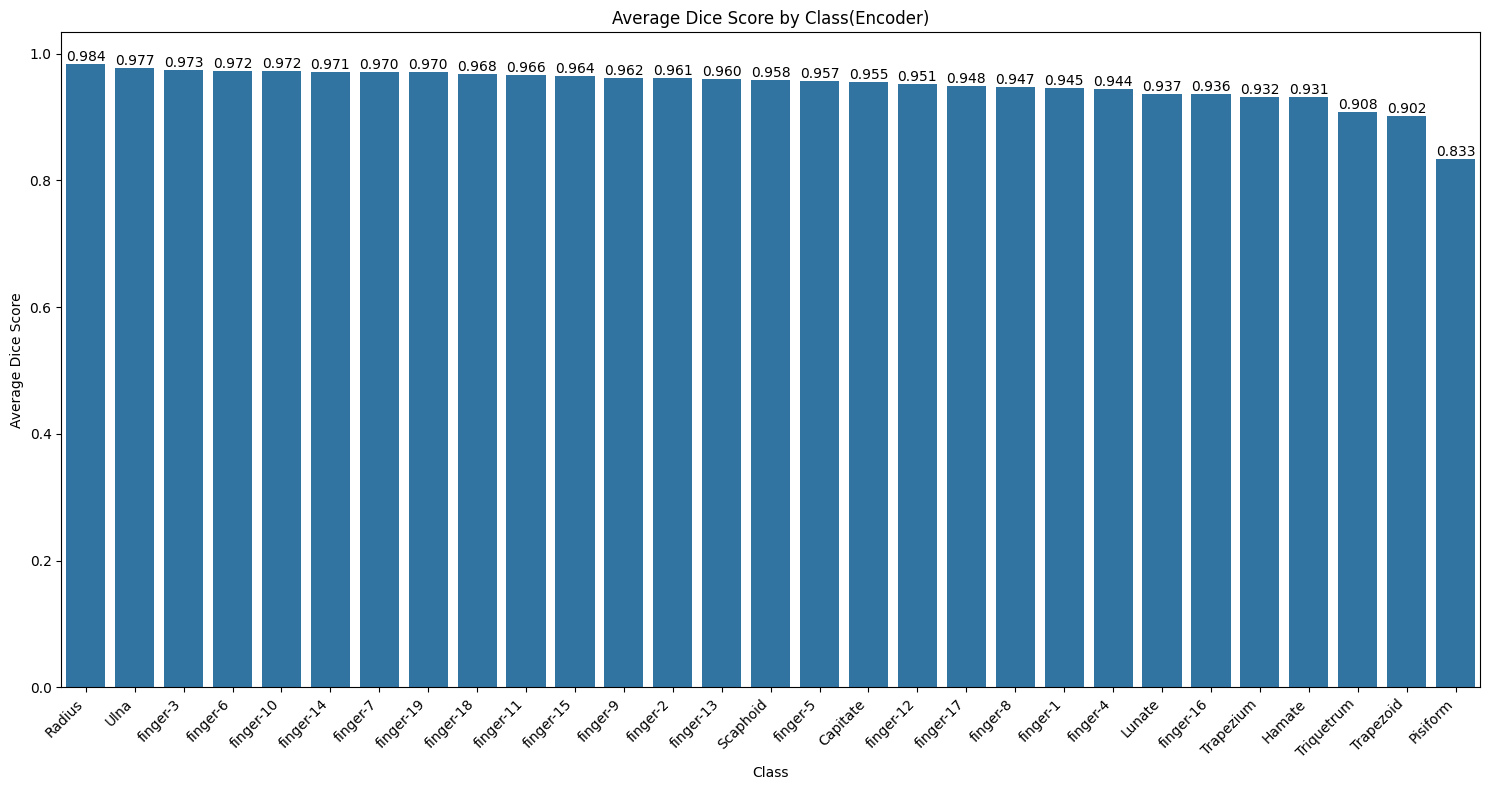

In [25]:
# 시각화
sorted_df = class_dice_df.sort_values('dice', ascending=False)

plt.figure(figsize=(15, 8))
ax = sns.barplot(x=sorted_df['class'], y=sorted_df['dice'])

for i, v in enumerate(sorted_df['dice']):
    ax.text(i, v, f'{v:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.title('Average Dice Score by Class(Encoder)')
plt.xlabel('Class')
plt.ylabel('Average Dice Score')
plt.tight_layout()
plt.show()

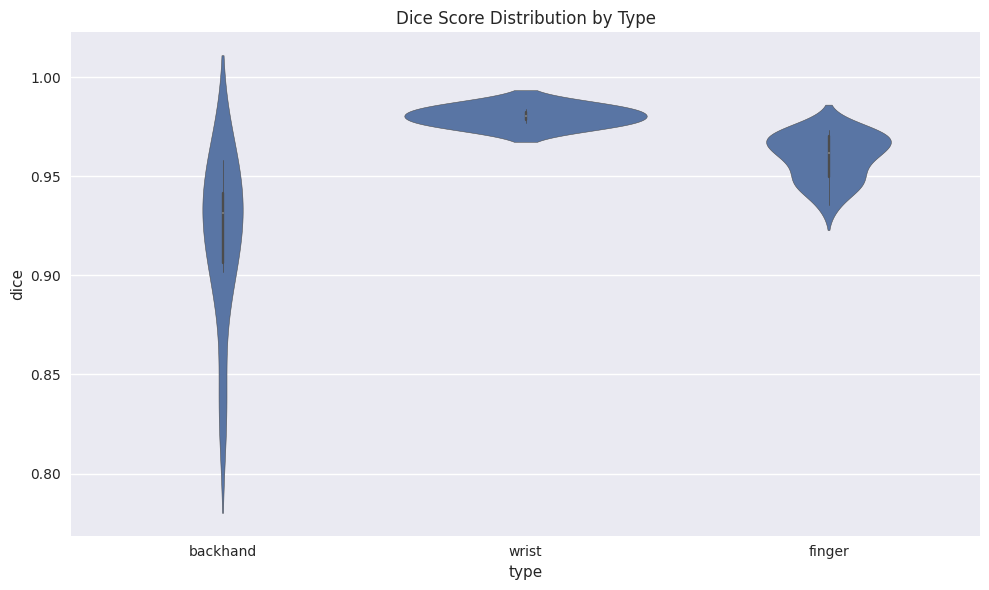

In [26]:
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [15, 10]

# 타입별 성능 분포 (Violin Plot)
plt.figure(figsize=(10, 6))
sns.violinplot(data=class_dice_df, x='type', y='dice')
plt.title('Dice Score Distribution by Type')
plt.tight_layout()
plt.show()